# The following script is designed to walk through the process of finding the lowest energy conformers for molecules using RDKit's force field method

We'll start by performing step by step analysis on a single molecule, then perform this analysis on a list of molecules, and finally develop a function to do this automatically

In [25]:
import os
import sys
import logging
FORMAT = "%(filename)s:%(lineno)d %(funcName)s %(levelname)s %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

import re
import imp
import itertools
import random
import numpy as np
from numpy import array
import pandas as pd
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns


# do this before we have a chance to import openbabel!
import rdkit, rdkit.Chem.rdDistGeom, rdkit.DistanceGeometry
from rdkit.Chem.rdMolTransforms import SetDihedralDeg

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase

import py3Dmol

from rmgpy.molecule import Molecule
from rmgpy.species import Species
from rmgpy.reaction import Reaction
from rmgpy.kinetics import PDepArrhenius, PDepKineticsModel

"""from rmgpy.data.rmg import RMGDatabase
from rmgpy.data.kinetics import KineticsDepository, KineticsRules
from rmgpy.qm.main import QMCalculator, QMSettings
from rmgpy.qm.qmdata import QMData
from rmgpy.qm.reaction import QMReaction
from rmgpy.qm.molecule import QMMolecule
"""

/Users/nathan/anaconda/envs/rmg_clone/lib/python2.7/site-packages/ipykernel_launcher.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/nathan/anaconda/envs/rmg_clone/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/nathan/anaconda/envs/rmg_clone/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/nathan/anaconda/envs/rmg_clone/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/nathan/anaconda/envs/amp/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/nat

'from rmgpy.data.rmg import RMGDatabase\nfrom rmgpy.data.kinetics import KineticsDepository, KineticsRules\nfrom rmgpy.qm.main import QMCalculator, QMSettings\nfrom rmgpy.qm.qmdata import QMData\nfrom rmgpy.qm.reaction import QMReaction\nfrom rmgpy.qm.molecule import QMMolecule\n'

In [26]:
def view_mol(mol):
    """
    A function designed to visulaize rdkit molecules
    
    Input: 
    * mol (an rdkit molecule object)
    
    Output: 
    * 3D figure of the molecule from py3Dmol
    
    """
    mb  = Chem.MolToMolBlock(mol)
    p = py3Dmol.view(width=400, height=400)
    p.addModel(mb, "sdf")
    p.setStyle({'stick':{}})
    p.setBackgroundColor('0xeeeeee')
    p.zoomTo()
    return p.show()
    
    

In [27]:
def calc_energy(mol):
    """
    A function designed to calculate the energy of a molecule or TS.
    
    Input: 
    * rdkit molecule object
    
    Output: 
    * energy of the geometry calculated using rdkit's forcefield method
    * the resultant rdkit molecule object
    """
    # Setting the force field parameters

        
    ff = rdkit.Chem.rdForceFieldHelpers.UFFGetMoleculeForceField(mol)#, molprop)
    
    
    
    return ff.CalcEnergy(), mol

In [28]:
def constrained_energy_calc(mol, list_of_torsions, angles):
    """
    A function designed to calculate the energy of a molecule or TS.
    For this function, the molecule torsions are fixed, 
    but the rest of the molecule is allowed to relax to a local minimum
    
    Input: 
    * rdkit molecule object
    * list of torsions as (i,j,k,l) tuples
    * list of angles to set the corresponding torsions to
    
    Output: 
    * energy of the geometry calculated using rdkit's forcefield method
    * the resultant rdkit molecule object
    """
    
    # Setting the force field parameters
    ff = rdkit.Chem.rdForceFieldHelpers.UFFGetMoleculeForceField(mol)
    
    # Zipping the torsion list and the angles together
    geometries = zip(list_of_torsions, angles)
    
    # Generating a conformer to edit
    tup = mol.GetConformers()
    conformer = tup[0]
    
    # Setting the corresponding torsion to their proper angles
    for geometry in geometries:
        
        i = geometry[0][0]
        j = geometry[0][1]
        k = geometry[0][2]
        l = geometry[0][3]
        angle = geometry[1]
        
        SetDihedralDeg(conformer,
                           i, 
                           j, 
                           k, 
                           l,
                           angle)
        
        # Constraining the torsions of the molecule
        ff.UFFAddTorsionConstraint(i,j,k,l, True, angle, angle, 1)
     

    #e, m = calc_energy(mol)
    # Optimizing the molecule
    AllChem.UFFOptimizeMolecule(mol)
    
    
    
    return ff.CalcEnergy(), mol

In [37]:
def optimize_and_calc(mol, list_of_torsions, angles):
    """
    A function designed to calculate the energy of a molecule or TS.
    For this function, the torsions of the molecule are set to their corresponding angles,
    then the molecule is allowed to relax to a local minimum
    
    Input: 
    * rdkit molecule object
    * list of torsions as (i,j,k,l) tuples
    * list of angles to set the corresponding torsions to
    
    Output: 
    * energy of the geometry calculated using rdkit's forcefield method
    * the resultant rdkit molecule object
    """
    
    # Setting the force field parameters 
    ff = rdkit.Chem.rdForceFieldHelpers.UFFGetMoleculeForceField(mol)
    
    # Zipping the torsions and their corresponding angles together
    geometries = zip(list_of_torsions, angles)
    
    # Generating conformers and selecting one
    tup = mol.GetConformers()
    conformer = tup[0]
    
    for geometry in geometries:
        # Setting the torsion angles
        i = geometry[0][0]
        j = geometry[0][1]
        k = geometry[0][2]
        l = geometry[0][3]
        angle = geometry[1]
        
        SetDihedralDeg(conformer,
                           i, 
                           j, 
                           k, 
                           l,
                           angle)
    
    # Allowing the molecule to relax
    AllChem.UFFOptimizeMolecule(mol)
    
    
    return ff.CalcEnergy(), mol

# This portion is for optimization of reactants and products 

In [38]:
test_mol = Chem.AddHs(Chem.MolFromSmiles(
    "COC(=O)Cc1ccccc1CC2CC(O)C(C(=C)CC#CCC=O)C2OO"
))

AllChem.EmbedMolecule(test_mol)

view_mol(test_mol)

# Example with one single rotor

For this we will be looking at methoxyethane. We chose this molecule because it has three local minima for it's one torsion. For now we will just test the above functions using this molecule

In [39]:
RDMol = Chem.AddHs(Chem.MolFromSmiles(
            "CCOC"
        ))
rdkit.Chem.AllChem.EmbedMolecule(RDMol)

view_mol(RDMol)

In [40]:
print rdkit.Chem.MolToMolBlock(RDMol)
RDMol = rdkit.Chem.rdchem.RWMol(RDMol)

e, m = calc_energy(RDMol)
print e
view_mol(m)


     RDKit          3D

 12 11  0  0  0  0  0  0  0  0999 V2000
   -1.3675    0.5099   -0.0511 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.4980   -0.6231    0.4299 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.5856   -0.8736   -0.3854 O   0  0  0  0  0  0  0  0  0  0  0  0
    1.6505   -0.0148   -0.2057 C   0  0  0  0  0  0  0  0  0  0  0  0
   -2.2351    0.5673    0.6463 H   0  0  0  0  0  0  0  0  0  0  0  0
   -1.7886    0.2354   -1.0302 H   0  0  0  0  0  0  0  0  0  0  0  0
   -0.8651    1.4855   -0.0642 H   0  0  0  0  0  0  0  0  0  0  0  0
   -0.1919   -0.4294    1.4655 H   0  0  0  0  0  0  0  0  0  0  0  0
   -1.1363   -1.5417    0.3961 H   0  0  0  0  0  0  0  0  0  0  0  0
    1.5332    0.5716    0.7382 H   0  0  0  0  0  0  0  0  0  0  0  0
    2.6232   -0.5670   -0.1782 H   0  0  0  0  0  0  0  0  0  0  0  0
    1.6901    0.6798   -1.0779 H   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  1  0
  2  3  1  0
  3  4  1  0
  1  5  1  0
  1  6  1  0
  1  7  1  0
  2  8  1  0
  2 

### Now we're going to find the indicies of the atoms participating in the torsion

In [41]:
rdkit.Chem.rdForceFieldHelpers.UFFGetMoleculeForceField

<function rdkit.Chem.rdForceFieldHelpers.UFFGetMoleculeForceField>

In [42]:

torsion_list = []

for bond1 in RDMol.GetBonds():
    
    atom1 = bond1.GetBeginAtom()
    atom2 = bond1.GetEndAtom()
    if atom1.IsInRing() or atom2.IsInRing() or atom1.GetAtomicNum() == 1 or atom2.GetAtomicNum() == 1:
        # Making sure that the atoms we're looking at are
        # not hydrogen or in a ring
        continue
    
    bond_list1 = list(atom1.GetBonds())
    bond_list2 = list(atom2.GetBonds())

    if not len(bond_list1) > 1 and not len(bond_list2) > 1:
        # Making sure that there are more than one bond attached to
        # the atoms we're looking at
        continue
        

    # Getting the 0th and 3rd atom and encuring that atoms 
    # attached to the 1st and 2nd atom are not all hydrogens
    # If not, we append a tuple of the torsion our torsion_list
    atom_count0 = 0
    hydrogen_count0 = 0
    
    for bond0 in bond_list1:
        atomX = bond0.GetOtherAtom(atom1)
        if atomX.GetIdx() != atom2.GetIdx():
            atom0 = atomX
            atom_count0 += 1
        if atomX.GetAtomicNum() == 1:
            hydrogen_count0 += 1
            
    atom_count1 = 0
    hydrogen_count1 = 0
            
    for bond2 in bond_list2:
        atomY = bond2.GetOtherAtom(atom2)
        if atomY.GetIdx() != atom1.GetIdx():
            atom3 = atomY
            atom_count1 += 1
        if atomY.GetAtomicNum() == 1:
            hydrogen_count1 += 1
            
    if atom_count0 != hydrogen_count0 and atom_count1 != hydrogen_count1:
        torsion_tup = (atom0.GetIdx(), atom1.GetIdx(), atom2.GetIdx(), atom3.GetIdx())
        torsion_list.append(torsion_tup)
    
torsion_list

[(8, 1, 2, 3)]

## Testing the `constrained_energy_calc` and the `optimize_and_calc` functions. 

**There are currently issues with the `constrained_energy_calc` function. Will debug this later**

In [43]:
e, mol,  = constrained_energy_calc(RDMol, torsion_list, [90])
print e
view_mol(mol)

10.4863532539


In [44]:
e, mol = optimize_and_calc(RDMol, torsion_list, [90])
print e
view_mol(mol)


6.93672090652


### Now we will loop through torsion angles ranging between 0 degrees to 360 degrees using increments of 10 degrees. We will calculate the enegy at each step and create a list of lists containing the energy and the torsion angle

In [45]:
torsion_angles = np.arange(0, 360+1,1)
torsion_combos = list( itertools.combinations_with_replacement( torsion_angles, len(torsion_list)) )
if len(torsion_list) != 1:
    torsion_combos = list(
        set(
            torsion_combos + 
            list(itertools.combinations_with_replacement( 
                torsion_angles[::-1], len(torsion_list)
            ))))

df = []


torsion_combos
tup = RDMol.GetConformers()
conformer = tup[0]
for combo in torsion_combos:
    

    geometry = zip(torsion_list, combo)
    
    for torsion in geometry:
        i = torsion[0][0]
        j = torsion[0][1]
        k = torsion[0][2]
        l = torsion[0][3]
        angle = torsion[1]
        
        SetDihedralDeg(conformer,
                       i, 
                       j, 
                       k, 
                       l,
                       angle)
    e0, m0 = calc_energy(RDMol)
    e1, m1 = constrained_energy_calc(RDMol, torsion_list, combo)
    e2, m2 = optimize_and_calc(RDMol, torsion_list, combo)
    
    df.append( [e0,
                e1,
                e2] 
              + list(combo))
    


In [46]:
i, j , k, l

(8, 1, 2, 3)

In [48]:
df = pd.DataFrame(df)
columns = ["No Optimization", "Partial Optimization", "Full Optimization"]
for i in range(len(torsion_list)):
    columns.append("Tor " + str(i))

df.columns = columns

df.sort_values("No Optimization")

,No Optimization,Partial Optimization,Full Optimization,Tor 0
299,5.172580,5.741008,5.172560,299
300,5.174542,5.704397,5.172560,300
298,5.175424,5.778836,5.172560,298
301,5.181305,5.669006,5.172560,301
297,5.183067,5.817883,5.172560,297
302,5.192852,5.634833,5.172560,302
296,5.195489,5.858149,5.172560,296
303,5.209154,5.601878,5.172560,303
295,5.212661,5.899633,5.172560,295
304,5.230172,5.570143,5.172560,304


### Finally we visualize the data

Also, our findings for this conformer analysis are similar to that of `http://onlinelibrary.wiley.com/doi/10.1002/jcc.10271/full`

Text(0.5,0,'Torsion')

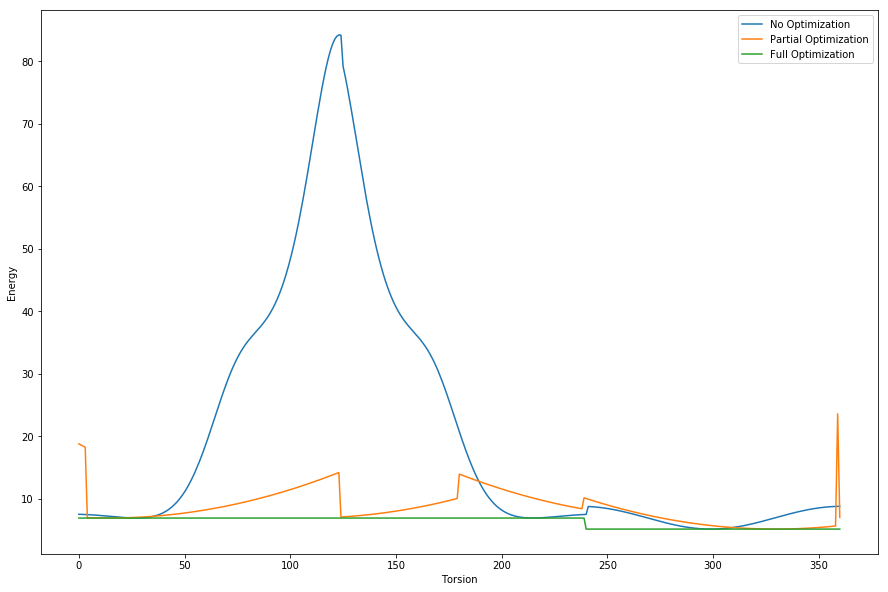

In [52]:
plot = df.sort_values("Tor 0").plot("Tor 0", figsize=(15,10))
plot.set_ylabel("Energy")
plot.set_xlabel("Torsion")
#plot.set_ylim([0,100])


# Next we'll be looking at this for a molecule with two rotors

For this, we're gonna choose COCOC. I feel like it would have multiple minima on the PES

In [53]:
RDMol = Chem.AddHs(Chem.MolFromSmiles(
            "COCCC"
        ))
rdkit.Chem.AllChem.EmbedMolecule(RDMol)

view_mol(RDMol)

## Again, getting the torsions

In [54]:

torsion_list = []

for bond1 in RDMol.GetBonds():
    
    atom1 = bond1.GetBeginAtom()
    atom2 = bond1.GetEndAtom()
    if atom1.IsInRing() or atom2.IsInRing() or atom1.GetAtomicNum() == 1 or atom2.GetAtomicNum() == 1:
        # Making sure that the atoms we're looking at are
        # not hydrogen or in a ring
        continue
    
    bond_list1 = list(atom1.GetBonds())
    bond_list2 = list(atom2.GetBonds())

    if not len(bond_list1) > 1 and not len(bond_list2) > 1:
        # Making sure that there are more than one bond attached to
        # the atoms we're looking at
        continue
        

    # Getting the 0th and 3rd atom and encuring that atoms 
    # attached to the 1st and 2nd atom are not all hydrogens
    # If not, we append a tuple of the torsion our torsion_list
    atom_count0 = 0
    hydrogen_count0 = 0
    
    for bond0 in bond_list1:
        atomX = bond0.GetOtherAtom(atom1)
        if atomX.GetIdx() != atom2.GetIdx():
            atom0 = atomX
            atom_count0 += 1
        if atomX.GetAtomicNum() == 1:
            hydrogen_count0 += 1
            
    atom_count1 = 0
    hydrogen_count1 = 0
            
    for bond2 in bond_list2:
        atomY = bond2.GetOtherAtom(atom2)
        if atomY.GetIdx() != atom1.GetIdx():
            atom3 = atomY
            atom_count1 += 1
        if atomY.GetAtomicNum() == 1:
            hydrogen_count1 += 1
            
    if atom_count0 != hydrogen_count0 and atom_count1 != hydrogen_count1:
        torsion_tup = (atom0.GetIdx(), atom1.GetIdx(), atom2.GetIdx(), atom3.GetIdx())
        torsion_list.append(torsion_tup)
    
torsion_list

[(0, 1, 2, 9), (9, 2, 3, 11)]

## We're doing 10 degree scans for this one because anything smaller would be obnoxious

In [55]:
torsion_angles = np.arange(0, 360+10,10)
torsion_combos = list( itertools.combinations_with_replacement( torsion_angles, len(torsion_list)) )
if len(torsion_list) != 1:
    torsion_combos = list(
        set(
            torsion_combos + 
            list(itertools.combinations_with_replacement( 
                torsion_angles[::-1], len(torsion_list)
            ))))

df = []

tup = RDMol.GetConformers()
conformer = tup[0]
for combo in torsion_combos:
    

    geometry = zip(torsion_list, combo)
    
    for torsion in geometry:
        i = torsion[0][0]
        j = torsion[0][1]
        k = torsion[0][2]
        l = torsion[0][3]
        angle = torsion[1]
        
        SetDihedralDeg(conformer,
                       i, 
                       j, 
                       k, 
                       l,
                       angle)
        
    e0, m0 = calc_energy(RDMol)
    e1, m1 = constrained_energy_calc(RDMol, torsion_list, combo)
    e2, m2 = optimize_and_calc(RDMol, torsion_list, combo)
    
    df.append( [e0,
                e1,
                e2] 
              + list(combo))
    


In [58]:
df = pd.DataFrame(df)
columns = ["No Optimization", "Partial Optimization", "Full Optimization"]
for i in range(len(torsion_list)):
    columns.append("Tor " + str(i))

df.columns = columns

df.sort_values("No Optimization")

,No Optimization,Partial Optimization,Full Optimization,Tor 0,Tor 1
1048,6.374616e+00,7.382288,6.326617,60,300
278,6.427992e+00,6.787512,6.025313,50,60
693,6.469252e+00,7.153112,6.326617,300,50
136,6.479223e+00,11.923538,6.326617,300,180
331,6.533174e+00,7.566496,6.326617,70,310
730,6.728189e+00,7.431869,6.326617,50,70
576,6.728190e+00,7.431869,6.326617,310,290
699,6.886798e+00,10.565709,6.326617,310,190
360,6.923444e+00,6.608998,6.025313,40,60
940,7.069396e+00,8.101726,6.326617,280,50


## Heat map for non-optimized data

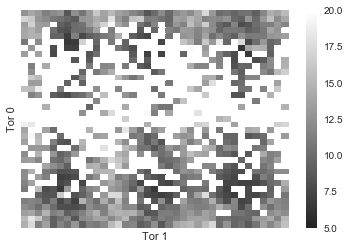

In [59]:
dff = df.pivot(index="Tor 0", columns="Tor 1", values="No Optimization")
sns.set()
sns.heatmap(dff, 
            cmap = sns.dark_palette("white", as_cmap=True), 
            vmin =5, vmax=20, 
            xticklabels=[], yticklabels=[])

## Heat map for partly optimized data 

TODO: This will need some fixing

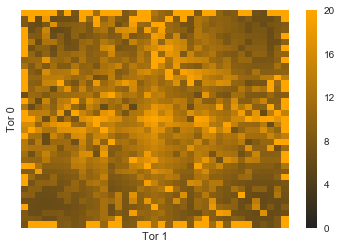

In [60]:
dff = df.pivot(index="Tor 0", columns="Tor 1", values="Partial Optimization")
sns.set()
sns.heatmap(dff,
            cmap = sns.dark_palette("orange", as_cmap=True),
            vmin = 0, vmax=20, 
            xticklabels=[], yticklabels=[])

## Heat map for fully optimized data

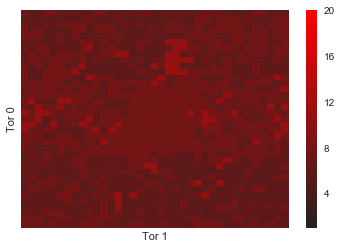

In [61]:
dff = df.pivot(index="Tor 0", columns="Tor 1", values="Full Optimization")
sns.set()
sns.heatmap(dff, 
            cmap = sns.dark_palette("red", as_cmap=True),
            vmin = 1, vmax=20, 
            xticklabels=[], yticklabels=[])

# This next portion is designed to do the above but for a variety of molecules

For this we are looking at a series of 5 molecules with a variety geometries

In [62]:
list_of_smiles = [
    'CCCC',
    'CCC#CC',
    'CCC=CCC',
    'CCOC',
    "CCCC1(CCC)OCC(C)C1"
]

for smiles in list_of_smiles:
    RDMol = Chem.AddHs(Chem.MolFromSmiles(
            smiles
        ))
    rdkit.Chem.AllChem.EmbedMolecule(RDMol)

    #print view_mol(RDMol)

    
    print rdkit.Chem.MolToMolBlock(RDMol)
    print
    RDMol = rdkit.Chem.rdchem.RWMol(RDMol)
    torsion_list = []

    for bond1 in RDMol.GetBonds():

        atom1 = bond1.GetBeginAtom()
        atom2 = bond1.GetEndAtom()
        if atom1.IsInRing() or atom2.IsInRing() or atom1.GetAtomicNum() == 1 or atom2.GetAtomicNum() == 1:
            # Making sure that the atoms we're looking at are
            # not hydrogen or in a ring
            continue

        bond_list1 = list(atom1.GetBonds())
        bond_list2 = list(atom2.GetBonds())

        if not len(bond_list1) > 1 and not len(bond_list2) > 1:
            # Making sure that there are more than one bond attached to
            # the atoms we're looking at
            continue


        # Getting the 0th and 3rd atom and encuring that atoms 
        # attached to the 1st and 2nd atom are not all hydrogens
        # If not, we append a tuple of the torsion our torsion_list
        atom_count0 = 0
        hydrogen_count0 = 0

        for bond0 in bond_list1:
            atomX = bond0.GetOtherAtom(atom1)
            if atomX.GetIdx() != atom2.GetIdx():
                atom0 = atomX
                atom_count0 += 1
            if atomX.GetAtomicNum() == 1:
                hydrogen_count0 += 1

        atom_count1 = 0
        hydrogen_count1 = 0

        for bond2 in bond_list2:
            atomY = bond2.GetOtherAtom(atom2)
            if atomY.GetIdx() != atom1.GetIdx():
                atom3 = atomY
                atom_count1 += 1
            if atomY.GetAtomicNum() == 1:
                hydrogen_count1 += 1

        if atom_count0 != hydrogen_count0 and atom_count1 != hydrogen_count1:
            torsion_tup = (atom0.GetIdx(), atom1.GetIdx(), atom2.GetIdx(), atom3.GetIdx())
            torsion_list.append(torsion_tup)
    print torsion_list
        
        
        

    torsion_angles = np.arange(0, 360+30,30)
    torsion_combos = list( itertools.combinations_with_replacement( torsion_angles, len(torsion_list)) )
    torsion_combos = torsion_combos + list(itertools.combinations_with_replacement( torsion_angles[::-1], len(torsion_list)) )

    df = []

    
    tup = RDMol.GetConformers()
    conformer = tup[0]
    for combo in torsion_combos:


        geometry = zip(torsion_list, combo)

        for torsion in geometry:
            i = torsion[0][0]
            j = torsion[0][1]
            k = torsion[0][2]
            l = torsion[0][3]
            angle = torsion[1]

            SetDihedralDeg(conformer,
                           i, 
                           j, 
                           k, 
                           l,
                           angle)
        
        e0, m0 = calc_energy(RDMol)
        e1, m1 = constrained_energy_calc(RDMol, torsion_list, combo)
        e2, m2 = optimize_and_calc(RDMol, torsion_list, combo)

        df.append( [e0, e1, e2,
                   m0, m1, m2] 
                  + list(combo))
        

    df = pd.DataFrame(df)
    columns = ["No Optimization Energy", "Partial Optimization Energy", "Full Optimization Energy",
              "No Optimization Mol", "Partial Optimization Mol", "Full Optimization Mol"]
    for i in range(len(torsion_list)):
        columns.append("Tor " + str(i))

    df.columns = columns

    print df.sort("Tor 0").iloc[0]
    print df.sort("Tor 0").iloc[0]["No Optimization Mol"]
    print
    
    print rdkit.Chem.MolToMolBlock(RDMol)
    print
    print


     RDKit          3D

 14 13  0  0  0  0  0  0  0  0999 V2000
   -1.5622    0.3481   -0.1548 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.5864   -0.5720    0.5498 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.6557   -0.6648   -0.3138 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.4741    0.5632   -0.0533 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.5343    1.3739    0.2466 H   0  0  0  0  0  0  0  0  0  0  0  0
   -1.2663    0.4475   -1.2296 H   0  0  0  0  0  0  0  0  0  0  0  0
   -2.5680   -0.0849   -0.0271 H   0  0  0  0  0  0  0  0  0  0  0  0
   -0.3187   -0.1608    1.5540 H   0  0  0  0  0  0  0  0  0  0  0  0
   -0.9955   -1.5871    0.6619 H   0  0  0  0  0  0  0  0  0  0  0  0
    0.3004   -0.7328   -1.3722 H   0  0  0  0  0  0  0  0  0  0  0  0
    1.2839   -1.5345   -0.0684 H   0  0  0  0  0  0  0  0  0  0  0  0
    2.3124    0.7022   -0.7787 H   0  0  0  0  0  0  0  0  0  0  0  0
    1.9415    0.4204    0.9540 H   0  0  0  0  0  0  0  0  0  0  0  0
    0.8633    1.4817    0

AttributeError: 'DataFrame' object has no attribute 'sort'

## The following functions should be what you need to get the lowest energy conformer

Moving forward one should just need to use the following function to get the minimum energy by force field optimization via RDkit


#### There are some issues with the following portion of the code... This might be because I changed some of the above functions around.

In [63]:
def get_rdmol(SMILES):
    """
    A function to get a rewritable RDKit molecule object from a smiles
    
    This will only work for actual molecules
    
    Input:
    * SMILES string
    
    Output:
    * Embeded rewritable RDKit molecule object with hydrogens
    
    """
    RDMol = Chem.AddHs(Chem.MolFromSmiles(
            SMILES
        ))
    rdkit.Chem.AllChem.EmbedMolecule(RDMol)
    
    RDMol = rdkit.Chem.rdchem.RWMol(RDMol)
    
    return RDMol

# Testing of the above function
m = get_rdmol("CCOC")
view_mol(m)

In [64]:
def get_torsion_list(RDMol):
    """
    A function to return a list of the possible torsions in an RDKit molecule
    
    Input:
    * RDKit molecule 
    
    Output:
    * list of tuples containing 4 indicies of atoms representing a torsion
    """
    torsion_list = []
    for bond1 in RDMol.GetBonds():
        atom1 = bond1.GetBeginAtom()
        atom2 = bond1.GetEndAtom()
        if atom1.IsInRing() or atom2.IsInRing():
            # Making sure that bond1 we're looking at are in a ring
            continue

        bond_list1 = list(atom1.GetBonds())
        bond_list2 = list(atom2.GetBonds())

        if not len(bond_list1) > 1 and not len(bond_list2) > 1:
            # Making sure that there are more than one bond attached to
            # the atoms we're looking at
            continue
            
        # Getting the 0th and 3rd atom and insuring that atoms 
        # attached to the 1st and 2nd atom are not terminal hydrogens
        # We also make sure that all of the atoms are properly bound together

        # If the above are satisified, we append a tuple of the torsion our torsion_list
        got_atom0 = False
        got_atom3 = False
            
        for bond0 in bond_list1:
            atomX = bond0.GetOtherAtom(atom1)
            if atomX.GetAtomicNum() == 1 and len(atomX.GetBonds()) == 1:
                # This means that we have a terminal hydrogen, skip this
                # NOTE: for H_abstraction TSs, a non teminal H should exist
                continue 
            if atomX.GetIdx() != atom2.GetIdx():
                got_atom0 = True
                atom0 = atomX

        for bond2 in bond_list2:
            atomY = bond2.GetOtherAtom(atom2)
            if atomY.GetAtomicNum() == 1 and len(atomY.GetBonds()) == 1:
                # This means that we have a terminal hydrogen, skip this
                continue 
            if atomY.GetIdx() != atom1.GetIdx():
                got_atom3 = True
                atom3 = atomY
        
        if not (got_atom0 and got_atom3):
            # Making sure atom0 and atom3 were not found
            continue

        # Looking to make sure that all of the atoms are properly bonded to eached
        if (
            RDMol.GetBondBetweenAtoms(atom0.GetIdx(), atom1.GetIdx()) and 
            RDMol.GetBondBetweenAtoms(atom1.GetIdx(), atom2.GetIdx()) and 
            RDMol.GetBondBetweenAtoms(atom2.GetIdx(), atom3.GetIdx())   ) : 

            torsion_tup = (atom0.GetIdx(), atom1.GetIdx(), atom2.GetIdx(), atom3.GetIdx())
            torsion_list.append(torsion_tup)
        
    return torsion_list

# Testing of the above function
get_torsion_list(m)

[(0, 1, 2, 3)]

In [65]:
def get_torsion_energies(RDMol, delta):
    """
    A function to take a rdkit molecule, identify the torsions, 
    and calculate the constrained, partially optimized and fully optimized energies
    at a number of torsions ranging from 0 to 360 degrees at `delta` degree increments
    
    Input:
    * RDMol: A rdkit molecule object
    * delta: `int` that describes the increment for the scan
    
    Output:
    * df: a pandas dataframe containing the following columns
        * Constrained energy
        * The rdkit molecule for which the constrained energy was calculated for
        * Partially optimized energy
        * The rdkit molecule for which the partially optimized energy was calculated for
        * Fully optimized energy
         The rdkit molecule for which the fully optimized energy was calculated for
        * Torsional angles for each possible torsion (starting at 0)
    
    """
    
    torsion_list = get_torsion_list(RDMol)

    torsion_angles = np.arange(0, 360 + delta, delta)
    torsion_combos = list( itertools.combinations_with_replacement(torsion_angles, len(torsion_list)) )
    if len(torsion_list) != 1:
        torsion_combos = list(
            set(
                torsion_combos + 
                list(itertools.combinations_with_replacement( 
                    torsion_angles[::-1], len(torsion_list)
                ))))

    df = []

    tup = RDMol.GetConformers()
    conformer = tup[0]
    for combo in torsion_combos:


        geometry = zip(torsion_list, combo)

        for torsion in geometry:
            
            i = torsion[0][0]
            j = torsion[0][1]
            k = torsion[0][2]
            l = torsion[0][3]
            angle = torsion[1]

            SetDihedralDeg(conformer,
                           i, 
                           j, 
                           k, 
                           l,
                           angle)

        e0, m0 = calc_energy(RDMol)
        e1, m1 = constrained_energy_calc(RDMol, torsion_list, combo)
        e2, m2 = optimize_and_calc(RDMol, torsion_list, combo)
        
        df.append( [e0, e1, e2,
                   m0, m1, m2] 
                  + list(combo))
        

    df = pd.DataFrame(df)
    columns = ["No Optimization Energy", "Partial Optimization Energy", "Full Optimization Energy",
              "No Optimization Mol", "Partial Optimization Mol", "Full Optimization Mol"]
    for i in range(len(torsion_list)):
        columns.append("Torsion " + str(i))

    df.columns = columns
    
    return df

# Testing of the above function
get_torsion_energies(m, 30)

,No Optimization Energy,Partial Optimization Energy,Full Optimization Energy,No Optimization Mol,Partial Optimization Mol,Full Optimization Mol,Torsion 0
0,165.964872,8.365346,6.936721,<rdkit.Chem.rdchem.RWMol object at 0x1a1a281260>,<rdkit.Chem.rdchem.RWMol object at 0x1a1a281260>,<rdkit.Chem.rdchem.RWMol object at 0x1a1a281260>,0
1,42.218038,7.143535,6.936721,<rdkit.Chem.rdchem.RWMol object at 0x1a1a281260>,<rdkit.Chem.rdchem.RWMol object at 0x1a1a281260>,<rdkit.Chem.rdchem.RWMol object at 0x1a1a281260>,30
2,22.878264,7.018351,6.936721,<rdkit.Chem.rdchem.RWMol object at 0x1a1a281260>,<rdkit.Chem.rdchem.RWMol object at 0x1a1a281260>,<rdkit.Chem.rdchem.RWMol object at 0x1a1a281260>,60
3,7.132599,7.989793,6.936721,<rdkit.Chem.rdchem.RWMol object at 0x1a1a281260>,<rdkit.Chem.rdchem.RWMol object at 0x1a1a281260>,<rdkit.Chem.rdchem.RWMol object at 0x1a1a281260>,90
4,7.485518,10.057849,6.936721,<rdkit.Chem.rdchem.RWMol object at 0x1a1a281260>,<rdkit.Chem.rdchem.RWMol object at 0x1a1a281260>,<rdkit.Chem.rdchem.RWMol object at 0x1a1a281260>,120
5,6.924640,7.365814,5.172560,<rdkit.Chem.rdchem.RWMol object at 0x1a1a281260>,<rdkit.Chem.rdchem.RWMol object at 0x1a1a281260>,<rdkit.Chem.rdchem.RWMol object at 0x1a1a281260>,150
6,5.172560,10.107363,5.172560,<rdkit.Chem.rdchem.RWMol object at 0x1a1a281260>,<rdkit.Chem.rdchem.RWMol object at 0x1a1a281260>,<rdkit.Chem.rdchem.RWMol object at 0x1a1a281260>,180
7,6.945328,7.365817,5.172560,<rdkit.Chem.rdchem.RWMol object at 0x1a1a281260>,<rdkit.Chem.rdchem.RWMol object at 0x1a1a281260>,<rdkit.Chem.rdchem.RWMol object at 0x1a1a281260>,210
8,8.812360,10.057829,6.936721,<rdkit.Chem.rdchem.RWMol object at 0x1a1a281260>,<rdkit.Chem.rdchem.RWMol object at 0x1a1a281260>,<rdkit.Chem.rdchem.RWMol object at 0x1a1a281260>,240
9,7.132608,7.989793,6.936721,<rdkit.Chem.rdchem.RWMol object at 0x1a1a281260>,<rdkit.Chem.rdchem.RWMol object at 0x1a1a281260>,<rdkit.Chem.rdchem.RWMol object at 0x1a1a281260>,270


In [68]:
def get_lowest_energy_conformers(RDMol, delta):
    """
    A function that returns a dict of the lowest energy conformers calculated in a variety of different ways
    
    Inputs:
    * RDMol: a rdkit molecule object
    * delta: `int` that describes the increment for the scan
    
    Outputs:
    * conformer_dict: `dict` containing optimization energies and molecules corresponding to 
                     three differnet calculators
    
    """
    
    conformer_dict = {}
    
    df = get_torsion_energies(RDMol, delta)
    
    conformer_dict["No Optimization"] = (
        df.sort_values("No Optimization Energy")["No Optimization Energy"].iloc[0],
        df.sort_values("No Optimization Energy")["No Optimization Mol"].iloc[0]
    )
    
    conformer_dict["Partial Optimization"] = (
        df.sort_values("Partial Optimization Energy")["Partial Optimization Energy"].iloc[0],
        df.sort_values("Partial Optimization Energy")["Partial Optimization Mol"].iloc[0]
    )
    
    conformer_dict["Full Optimization"] = (
        df.sort_values("Full Optimization Energy")["Full Optimization Energy"].iloc[0],
        df.sort_values("Full Optimization Energy")["Full Optimization Mol"].iloc[0]
    )
    
    return conformer_dict

# Testing of the above function
conformer_dict = get_lowest_energy_conformers(m, 30)  
conformer_dict
    

{'Full Optimization': (5.172560135947858,
  <rdkit.Chem.rdchem.RWMol at 0x1a1a281260>),
 'No Optimization': (5.172560136064678,
  <rdkit.Chem.rdchem.RWMol at 0x1a1a281260>),
 'Partial Optimization': (7.018350767925527,
  <rdkit.Chem.rdchem.RWMol at 0x1a1a281260>)}

### Visualizing the three low energy conformers

In [69]:
print conformer_dict["No Optimization"][0]
view_mol(conformer_dict["No Optimization"][1])

5.172560136064678


In [70]:
print conformer_dict["Partial Optimization"][0]
view_mol(conformer_dict["Partial Optimization"][1])

7.018350767925527


In [71]:
print conformer_dict["Full Optimization"][0]
view_mol(conformer_dict["Full Optimization"][1])

5.172560135947858


## Now for some complex molecules

**NOTE:** These examples are set as markdown cells because they take a very long time to run

In [72]:
test_mol = get_rdmol("CCCC(CC)C")
conformer_dict = get_lowest_energy_conformers(test_mol, 30)
print conformer_dict["Full Optimization"][0]
view_mol(conformer_dict["Full Optimization"][1])

8.266789940468936


In [73]:
test_mol = get_rdmol("C1OCCC1(CCOC)CONC")
conformer_dict = get_lowest_energy_conformers(test_mol, 30)
print conformer_dict["Full Optimization"][0]
view_mol(conformer_dict["Full Optimization"][1])

24.965733772792124
